In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import wrds

In [2]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='lilas_bertot')


WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\desch\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# a) Statistiques descriptives des rendements

In [44]:
#Paramètres: 

TICKER = "LNC"
ALPHA = 0.05
FENETRE_MOBILE = 250
DEPART_MIN = 250
START = "2015-01-01"
END = None 

In [45]:
# Traitements des données 

def fetch_returns_wrds(ticker: str, start="2015-01-01", end=None):
    import wrds, certifi

    db = wrds.Connection(sslmode="verify-ca", sslrootcert=certifi.where())

    sql = f"""
        SELECT a.date, a.ret
        FROM crsp.dsf a
        JOIN crsp.stocknames b ON a.permno = b.permno
        WHERE b.ticker = '{ticker}'
          AND a.date >= '{start}'
          {f"AND a.date <= '{end}'" if end else ""}
        ORDER BY a.date
    """

    df = db.raw_sql(sql)
    df = df.dropna().rename(columns={"date": "Date", "ret": "Rendement"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()

    return df

def charger_rendements(ticker: str):
    rendements = fetch_returns_wrds(ticker, start="2015-01-01", end=None)
    return rendements, "WRDS/CRSP"


In [ ]:
# a) Statistiques descriptives des rendements

def statistiques_descriptives(x: pd.Series) -> pd.DataFrame:
    x = x.dropna()
    mean = x.mean()
    std = x.std(ddof=1)
    skew = ((x - mean) ** 3).mean() / (std ** 3)
    kurt = ((x - mean) ** 4).mean() / (std ** 4) - 3
    return pd.DataFrame({
        "Moyenne": [mean],
        "Écart-type": [std],
        "Asymétrie": [skew],
        "Kurtose (excès)": [kurt]
    })

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\desch\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done

(a) Données utilisées : LNC

Statistiques descriptives :
 Moyenne  Écart-type  Asymétrie  Kurtose (excès)
0.000322    0.028998  -0.261543        23.339687


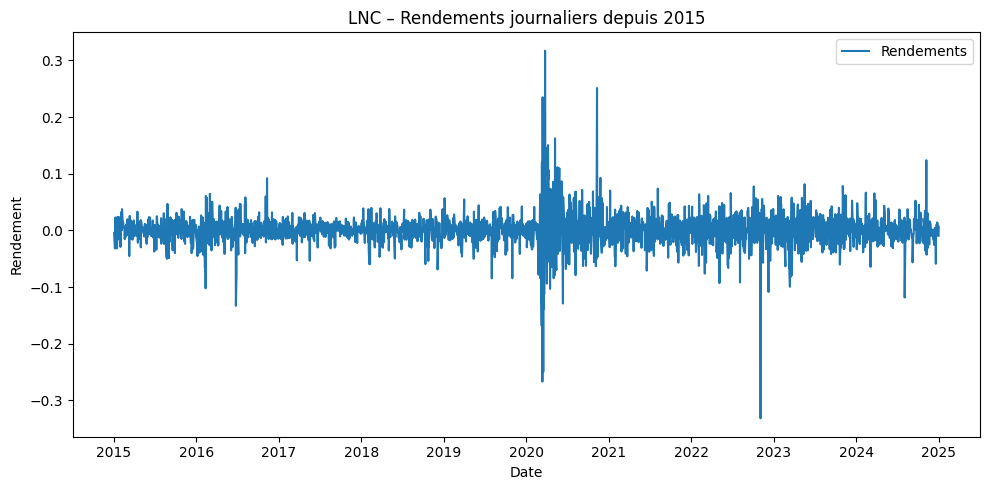

In [49]:
TICKER = "LNC" 
rendements, src = charger_rendements(TICKER)

print(f"\n(a) Données utilisées : {TICKER}")
stats = statistiques_descriptives(rendements["Rendement"])
print("\nStatistiques descriptives :")
print(stats.to_string(index=False))

plt.figure(figsize=(10, 5))
plt.plot(rendements.index, rendements, label="Rendements")
plt.title(f"{TICKER} – Rendements journaliers depuis 2015")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.tight_layout()
plt.show()

# b) Calcul de la VaR Historique avec une fenêtre mobile

In [50]:
# b) Calcul de la VaR mobile

r = rendements["Rendement"].dropna()  


var_roul = r.rolling(FENETRE_MOBILE, min_periods=FENETRE_MOBILE).quantile(ALPHA)
viol = (r < var_roul)

print(f"VaR mobile 5 % ({FENETRE_MOBILE} jours) : {viol.sum()} violations sur {len(viol)} obs ({viol.mean():.2%})")


VaR mobile 5 % (250 jours) : 405 violations sur 7548 obs (5.55%)


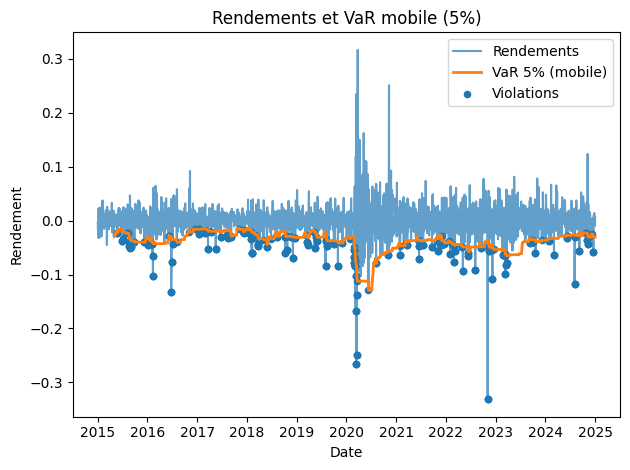

In [41]:
# b) graphique VaR mobile 
plt.figure()
plt.plot(r.index, r, label="Rendements", alpha=0.7)
plt.plot(var_roul.index, var_roul, label="VaR 5% (mobile)", linewidth=2)
plt.scatter(r.index[viol], r[viol], label="Violations", s=20)
plt.title("Rendements et VaR mobile (5%)")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\desch\AppData\Local\Temp\ipykernel_5448\3878813639.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  viol_annuel = viol.dropna().astype(int).resample("Y").sum()


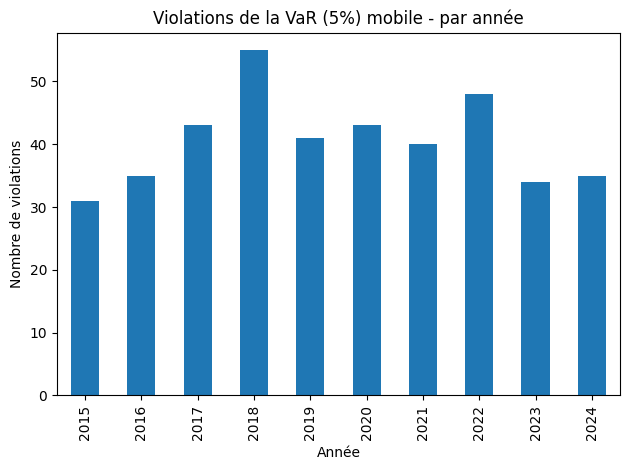

In [40]:
# b) histogramme annuel du nombre de violations
viol_annuel = viol.dropna().astype(int).resample("Y").sum()

plt.figure()
viol_annuel.index = viol_annuel.index.year
viol_annuel.plot(kind="bar")
plt.title("Violations de la VaR (5%) mobile - par année")
plt.xlabel("Année")
plt.ylabel("Nombre de violations")
plt.tight_layout()
plt.show()

# C) Calcul de la VaR historique avec une fenêtre expansive

In [ ]:
# c) Calcul de la VaR expansive

var_exp = r.expanding(min_periods=DEPART_MIN).quantile(ALPHA)

# violations (rendement plus petit que VaR expansive)
viol_exp = (r < var_exp)

print(f"VaR expansive 5 % (départ {DEPART_MIN} obs) : {viol_exp.sum()} violations sur {len(viol_exp)} obs ({viol_exp.mean():.2%})")

VaR expansive 5 % (départ 250 obs) : 476 violations sur 7548 obs (6.52%)


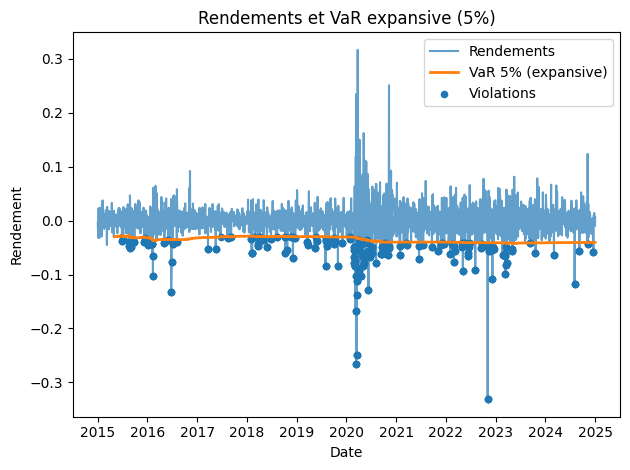

In [39]:
# c) graphique de la VaR expansive
plt.figure()
plt.plot(r.index, r, label="Rendements", alpha=0.7)
plt.plot(var_exp.index, var_exp, label="VaR 5% (expansive)", linewidth=2)
plt.scatter(r.index[viol_exp], r[viol_exp], label="Violations", s=20)  

plt.title("Rendements et VaR expansive (5%)")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\desch\AppData\Local\Temp\ipykernel_5448\2001711789.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  viol_exp_annuel = viol_exp.dropna().astype(int).resample("Y").sum()


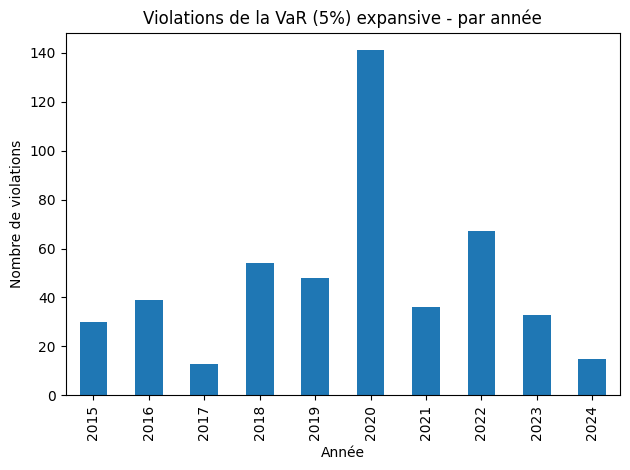

In [ ]:
# c) histogramme annuel des violations 
viol_exp_annuel = viol_exp.dropna().astype(int).resample("Y").sum()
plt.figure()
viol_exp_annuel.index = viol_exp_annuel.index.year
viol_exp_annuel.plot(kind="bar")
plt.title("Violations de la VaR (5%) expansive - par année")
plt.xlabel("Année")
plt.ylabel("Nombre de violations")
plt.tight_layout()
plt.show()